In [2]:
import numpy as np
import pandas as pd
import lostruct as ls
from skbio.stats.ordination import pcoa
import plotly.express as px
import plotly.graph_objects as go
import phate
from collections import Counter
import phate
import umap
import statistics as stats
#import hdbscan
import phate
from sklearn.decomposition import PCA

In [3]:
#vcf_file = "../trained_filtered.bcf"
#vcf_file = "../Trained.bcf"
vcf_file = "../Filtered_q0.05_F_MISSING_0.2_snpsonly.bcf"
landmarks = ls.get_landmarks(vcf_file)
samples = ls.get_samples(vcf_file)

In [4]:
results = list()
snp_positions = list()
snps = list()

for landmark in landmarks:
    windows, positions = ls.parse_vcf(vcf_file, landmark, 450)
    for i, window in enumerate(windows):
        snps.append(window)
        results.append(ls.eigen_windows(window, 10, 1))
        snp_positions.append([landmark, positions[i]])

In [5]:
len(snp_positions)

2762

In [6]:
#results

In [7]:
# Parse VCF to get windows and positions of each SNP within each window
#windows, positions = ls.parse_vcf(vcf_file, "S3", 250)
# ls.Window.SNP specifies window sizes are by SNP count. ls.Window.BP specifies windows are in base pair lengths.

# *** ls.Window.BP is not yet implemented, however. ***
# Please see: https://github.com/jguhlin/lostruct-py/issues/8

# Accumulate output of eigen_windows
#result = list()
#for x in windows:
#    result.append(ls.eigen_windows(x, 2, 1))

In [8]:
# Convert to numpy array
result = np.vstack(results)

/home/josephguhlin/.asdf/installs/python/mambaforge/envs/kakapo_figures_2023/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [9]:
# Get PCA distances comparison matrix
#pc_dists = ls.get_pc_dists(result)

In [10]:
# An additional mode, fastmath, is available. Trading some accuracy for a slight speed boost (~8%)
pc_dists = ls.get_pc_dists(result, fastmath=True)

In [11]:
pc_dists[:5]

array([[0.        , 0.54880513, 0.61520243, ..., 0.68600422, 0.71130633,
        0.75319117],
       [0.54880513, 0.        , 0.62569143, ..., 0.70360012, 0.72903349,
        0.77368664],
       [0.61520243, 0.62569143, 0.        , ..., 0.58891268, 0.61072791,
        0.67542635],
       [0.79225239, 0.82090472, 0.57628962, ..., 0.76720631, 0.77515069,
        0.82925249],
       [0.75024219, 0.7628043 , 0.55509803, ..., 0.70503112, 0.71532178,
        0.75646617]])

In [12]:
#pc_dists = np.load("pc_dists.npy")
np.save("localpca_all_results_q05.npy", result)
np.save("localpca_all_q05.npy", pc_dists)
np.save("localpca_all_positions_q05.npy", snp_positions)

/home/josephguhlin/.asdf/installs/python/mambaforge/envs/kakapo_figures_2023/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
result = np.load("localpca_all_results_q05.npy", allow_pickle=True)
pc_dists = np.load("localpca_all_q05.npy", allow_pickle=True)
snp_positions = np.load("localpca_all_positions_q05.npy", allow_pickle=True)
results = result

In [ ]:
pc_dists.shape

In [14]:
pc_dists[0]

array([0.        , 0.54880513, 0.61520243, ..., 0.68600422, 0.71130633,
       0.75319117])

In [62]:
# Get PCoA value of pc_dists matrix (this is equivalent to R's MDS)
# PLEASE NOTE: See section below: Working with Large Datasets
# For recommended ways to run pcoa

mds = pcoa(pc_dists, inplace=False, method="fsvd", number_of_dimensions=10)
#mds = pcoa(pc_dists[:2500, :2500], inplace=True, method="fsvd", number_of_dimensions=6)

In [63]:
mean = np.mean(mds.samples["PC1"])
sd = np.std(mds.samples["PC1"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC1"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds1.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [64]:
mean = np.mean(mds.samples["PC2"])
sd = np.std(mds.samples["PC2"])

previous_pos = 0
highlights = list()
current_chr = "S1"
current_start = 0
current_end = 0

for pos in np.where(np.abs(mds.samples["PC2"]) >= mean + 2 * sd)[0]:
    if pos == previous_pos + 1:
        current_end = snp_positions[pos][1][-1]
    else:
        #print("Previous: {} cur: {}".format(previous_pos, pos))

        if previous_pos != 0:
            highlights.append((current_chr, current_start, current_end))
        
        current_chr   = snp_positions[pos][0]
        current_start = snp_positions[pos][1][0]
        current_end   = snp_positions[pos][1][-1]
        previous_pos = pos

with open("mds2.highlight", 'w') as writer:
    for x in highlights:
        writer.write("\t".join(map(str, x)))
        writer.write("\n")

In [65]:
from itertools import cycle

In [66]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]
chrs = [i[0] for i in snp_positions]
colorfn = cycle(["#7D9D33", "#DCC949", "#BCA888", "#CD8862", "#775B24"])
colors = [next(colorfn) for _ in chrs]

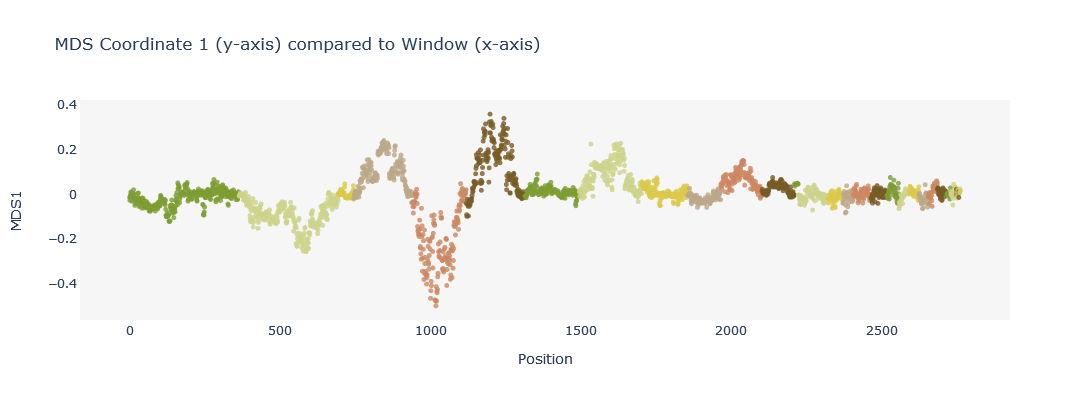

In [67]:
fig = px.scatter(y=mds.samples["PC1"], 
                 title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=400
                )

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS1"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord1.svg")
fig.write_image("mds_coord1.png")
fig

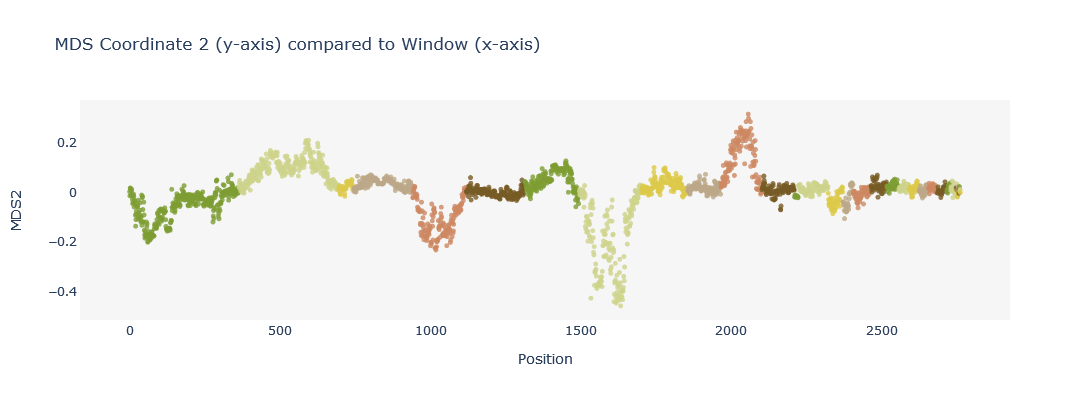

In [68]:
#px.scatter(y=mds.samples["PC2"], title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)")
fig = px.scatter(y=mds.samples["PC2"], 
                 title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=400
                )

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord2.svg")
fig.write_image("mds_coord2.png")
fig

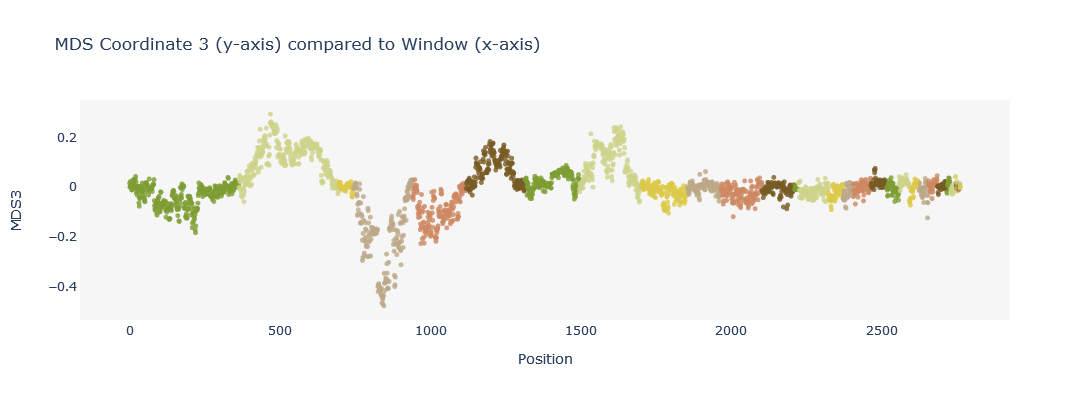

In [69]:
#px.scatter(y=mds.samples["PC2"], title="MDS Coordinate 2 (y-axis) compared to Window (x-axis)")
fig = px.scatter(y=mds.samples["PC3"], 
                 title="MDS Coordinate 3 (y-axis) compared to Window (x-axis)", 
                 color=chrs, 
                 labels=chrs,
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=400
                )

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="Position"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="MDS3"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mds_coord3.svg")
fig.write_image("mds_coord3.png")
fig

# The rest is exploratory

Above used to create figures and process the data, the rest are just explorations of the data

In [ ]:
[np.mean(mds.samples["PC1"]), np.std(mds.samples["PC1"])]

In [ ]:
twosd = np.mean(mds.samples["PC1"]) + 5 * np.std(mds.samples["PC1"])
mds.samples["PC1"][np.abs(mds.samples["PC1"]) >= twosd]


In [ ]:
result[620][3].shape

In [ ]:
# PC1 is really PC0...
pc = 1

output = list()
pc = pc - 1

for i, name in enumerate(samples):
    output.append(result[620][3][pc, i])
    # print(result[620][3][pc, i])

In [ ]:
px.scatter(x=output)

In [ ]:
#for j in snp_positions:
#    print(j[1])

In [ ]:
snp_positions[1][1][125]

In [ ]:
mds.samples["PC1"]

In [ ]:
with open("pc2.scatter", 'w') as writer:
    for i,_ in enumerate(snp_positions):
        output_line = list()
        output_line.append(snp_positions[i][0])
        output_line.append(snp_positions[i][1][0])
        output_line.append(snp_positions[i][1][-1])
        output_line.append(mds.samples["PC2"][i])
        writer.write("\t".join(map(str, output_line)))
        writer.write("\n")

In [ ]:
result.shape

In [ ]:
[mds.samples["PC2"].min(), mds.samples["PC2"].max()]

In [ ]:
[np.mean(mds.samples["PC1"]), np.std(mds.samples["PC1"])]

In [ ]:
np.argmin(np.abs(mds.samples["PC1"]) + np.abs(mds.samples["PC2"]))

# Getting the colors rights

In [ ]:
kakapo_colors = ["#7D9D33", "#CED38C", "#DCC949", "#BCA888", "#CD8862", "#775B24"]

# Local PCA Windows, zoom in

In [ ]:
colors = [x == "Richard_Henry" for x in samples]

In [ ]:
results[80][3].T.shape

In [ ]:
fig = px.scatter(x=results[875][3][0], 
                 y=results[875][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_875.svg")
fig


In [ ]:
fig = px.scatter(x=results[3173][3][0], 
                 y=results[3173][3][1], 
                 color=colors, 
                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("window_3173.svg")
fig


In [ ]:
results[80][3][1].shape

# Global Mean PCA From Plink

In [ ]:
ev = pd.read_csv("pop.eigenval", header=None)
ev = ev.to_numpy().flatten()
ev

In [ ]:
[ev[0]/np.sum(ev), ev[1]/np.sum(ev)]

In [ ]:
plink2 = pd.read_csv("pop.eigenvec", sep="\t")
plink2.head()

In [ ]:
rh

In [ ]:
fig = px.scatter(x=plink2['PC1'], 
                 y=plink2['PC2'], 
                 #color=colors, 
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=800,
                 #text=plink2["#IID"],
                 template="plotly_white")

rh = plink2[plink2['#IID'] == "Richard_Henry"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Richard Henry", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Barnard"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Barnard", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Jean"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Jean", showarrow=False, yshift=15)
rh = plink2[plink2['#IID'] == "Flossie"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Flossie", showarrow=False, yshift=15, xshift=20)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1 (43.5% Variance)"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2 (10.5% Variance)"))
#fig.update_layout(paper_bgcolor="white")
#fig.update_layout(plot_bgcolor="#f6f6f6")


fig.write_image("global_pca_all.svg")
fig.write_image("global_pca_all.png")

fig

## Global Mean PCA Plink2 Founders Only

In [ ]:
ev = pd.read_csv("founders35.eigenval", header=None)
ev = ev.to_numpy().flatten()
ev

In [ ]:
[ev[0]/np.sum(ev), ev[1]/np.sum(ev)]

In [ ]:
plink2 = pd.read_csv("founders35.eigenvec", sep="\t")
plink2.head()

In [ ]:
float(rh['PC1'])

In [ ]:
fig = px.scatter(x=plink2['PC1'], 
                 y=plink2['PC2'], 
                 #color=colors, 
                 color_discrete_sequence=kakapo_colors,
                 width=1200, height=800,
                 #text=plink2["#IID"],
                 template="plotly_white")

rh = plink2[plink2['#IID'] == "Richard_Henry"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Richard Henry", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Barnard"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Barnard", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Jean"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Jean", showarrow=False, yshift=15)

rh = plink2[plink2['#IID'] == "Flossie"]
fig.add_annotation(x=float(rh['PC1']), y=float(rh['PC2']), text="Flossie", showarrow=False, yshift=15)


fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1 (38.2% Variance)"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2 (12.8% Variance)"))
fig.update_traces(textposition='bottom center')
#fig.update_layout(paper_bgcolor="white")
#fig.update_layout(plot_bgcolor="#f6f6f6")

#fig.add_annotation(x=0.578114, y=-0.024875, text="Richard Henry", showarrow=False, yshift=15) #, yshift=0.001)

fig.write_image("global_pca_founders35.svg")
fig.write_image("global_pca_founders35.png")



fig

## Global Mean PCA

In [ ]:
snps_new = list()
for j in snps:
    snps_new.append(j.todense())

snps = np.asarray(snps_new)


In [ ]:
snps.shape

In [ ]:
snps = np.reshape(snps, (3062*450, 169))
snps.shape

In [ ]:
snps_nomissing = snps[~np.isnan(snps).any(axis=1), :]
snps_nomissing.shape

In [ ]:
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
pcs = pca.fit_transform(StandardScaler().fit_transform(snps_nomissing.T))

In [ ]:
pcs.shape

In [ ]:
pcs = StandardScaler().fit_transform(pcs)

In [ ]:
# Plot for Supplemental

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], 
#                 color=colors,
#                 color_discrete_sequence=["#7D9D33", "#CD8862"],
                 width=500, height=400)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig

In [ ]:
# Larger founder relatedness plot

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples,
                 labels=samples, text=samples,
                 color_discrete_sequence=kakapo_colors,
                 width=800, height=800)

fig.update_traces(marker=dict(size=8, opacity=0.95, line=dict(width=1, color='DarkSlateGray')))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC1"))
fig.update_layout(yaxis=dict(showgrid=False, zeroline=False, showline=True, title="PC2"))
fig.update_layout(paper_bgcolor="white")
fig.update_layout(plot_bgcolor="#f6f6f6")
fig.write_image("mean_pca.svg")
fig.update_traces(textposition='top center')
fig.write_image("founders_relatedness_large.svg")

fig

In [ ]:
pca.explained_variance_ratio_

# From previous calc

In [ ]:
pcs = list()
for result in results:
    print(result[3].T.shape)
    break
    pcs.append(result[3].T)

    #for x in result[3].T:
    #    print(x.shape)
    #    pcs.append(x)
    #    print(x)
    #    break

In [ ]:
np.asarray(pcs).shape

In [ ]:
pcs = np.mean(pcs, axis=1)
pcs.shape

In [ ]:
px.scatter(x=pcs[:, 0], y=pcs[:, 1], color=samples)

In [ ]:
plink2 = pd.read_csv("plink2.eigenvec", sep="\t")
plink2

In [ ]:
px.scatter(x=plink2["PC1"], y=plink2["PC2"], color=plink2["#IID"])

In [ ]:
px.scatter(y=mds.samples["PC1"], title="MDS Coordinate 1 (y-axis) compared to Window (x-axis)")

In [ ]:
def get_furthest_individuals(results):
    furthest = list()
    for n,result in enumerate(results):
        d = dict()
        vals = list()
        for i,x in enumerate(result[3].T):
            centroid = np.mean(result[0][3].T, axis=0)
            dist = np.linalg.norm(x-centroid)
            d[dist] = i
            vals.append(dist)
        vals = sorted(vals)
        vals.reverse()
        furthest.append((n, samples[d[vals[0]]]))
        #tops = [samples[d[x]] for x in vals[0]]
        #tops.sort()
        
        #furthest.append(tuple(tops))
    return furthest

get_furthest_individuals(result)

In [ ]:
bychr_pop = list()

for n in range(len(result)):
    toplot = result[n][3]
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(toplot.T)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
    clusterer.fit(embedding)
    
    d = dict()
    
    for i in clusterer.labels_:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    
    bychr_pop.append(d)

In [ ]:
groups = dict()
plot_data = list()

z = list(bychr_pop[0].keys())
z.sort()
z

for n in bychr_pop:
    for i in range(-1, 7):
        if i not in groups:
            groups[i] = list()
        if i not in n:
            groups[i].append(0)
        else:
            groups[i].append(n[i])
        #plot_data.append(bychr_pop[0][i])


In [ ]:
groups.keys()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[-1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[0]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[1]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[2]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[3]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[4]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[5]))
fig.add_trace(go.Bar(x=list(range(len(groups[0]))), y=groups[6]))

fig.update_layout(barmode='stack')


In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=samples)

In [ ]:
[positions[pc_loc][0], positions[pc_loc][-1]]

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.5)
clusterer.fit(embedding)

In [ ]:
clusterer.labels_

In [ ]:
px.scatter(x=embedding[:,0], y=embedding[:,1], color=clusterer.labels_)

In [ ]:
fig = go.Figure(data=go.Scattergl(
    y = mds_windows['PC1'],
))
fig.show()

In [ ]:
mds_windows

In [ ]:
pc_dists = np.load("pc_dists.npy")

In [ ]:
pc_dists[0]